In [ ]:
from pathlib import Path
import os
from fastai.vision.all import *
from fastai.callback.wandb import *
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.tracker import SaveModelCallback
from drone_detector.engines.fastai.data import *
from drone_detector.metrics import JaccardCoeffMulti

# Model training

In [ ]:
outpath = Path('../data/processed/train')

In [ ]:
patches = sorted(os.listdir(outpath/'1984'/'raster_tiles'))
val_files = patches[int(len(patches)*.75):]

Modify `SegmentationDataLoaders` so that we can specify the tiles to use as validation data during training. This prevents data leakage and overly optimistic results.

In [ ]:
class SegmentationDataLoadersFix(DataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for segmentation problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, codes=None, item_tfms=None, batch_tfms=None, 
                        img_cls=PILImage,val_fnames=None,**kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock(img_cls), MaskBlock(codes=codes)),
                           splitter=FuncSplitter(lambda o: o.name in val_files) if val_fnames else RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [ ]:
outpath = Path('../data/processed/train/')
fnames = [Path(outpath/year/'raster_tiles'/f) for year in ['1965', '1984'] 
          for f in os.listdir(outpath/year/'raster_tiles')]

The models are trained using [fastai] library. During training, the images are randomly flipped horizontally, brightness and contrast and saturation are randomly adjusted, images are rotated randomly (maximum rotation 5 degrees) and random areas are erased from the images.

In [ ]:
dls = SegmentationDataLoadersFix.from_label_func('../data/', bs=8,
                                              codes = ['Background',
                                                       'Fields',
                                                       'Marshes',
                                                       'Roads',
                                                       'Waterways',
                                                       'Water bodies'],
                                              fnames=fnames,
                                              label_func=(partial(label_from_different_folder,
                                                                 original_folder='raster_tiles',
                                                                 new_folder='mask_tiles')),
                                              batch_tfms = [
                                                  *aug_transforms(max_rotate=5., 
                                                                  max_warp=0., 
                                                                  max_zoom=1,
                                                                  pad_mode='zeros',
                                                                  xtra_tfms=[
                                                  Saturation(max_lighting=0.3)]),
                                                  RandomErasing(max_count=2),
                                                  Normalize.from_stats(*imagenet_stats)
                                              ],
                                               num_workers=0, val_files=val_files)

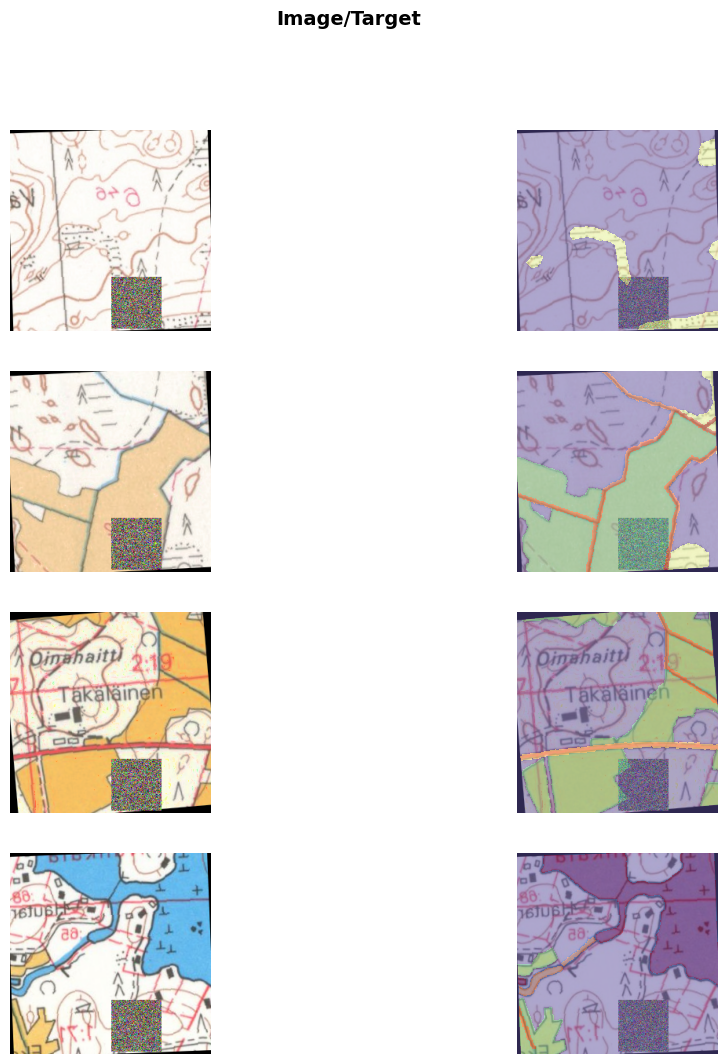

In [ ]:
dls.show_batch(max_n=8, cmap='Spectral_r', vmin=0, vmax=5)

We used U-Net  [(Roenneberger, Fischer and Brox, 2015)](https://arxiv.org/abs/1505.04597) architecture with ResNet152 as the encoder and Focal Loss as the loss function. The model evaluation metrics are Dice and Jaccard coefficients for multiclass tasks. Dice coefficient is twice the area of overlap in pixels divided by the total number of pixels in the images, while Jaccard coefficient is the area of intersection divided by the area of union. Both metrics are computed for each class separately, and then averaged. 

In [ ]:
learn = unet_learner(dls, arch=resnet152, pretrained=True, n_in=3, n_out=6, blur=False, self_attention=False,
                     metrics=[DiceMulti(), JaccardCoeffMulti()], loss_func=DiceLoss(axis=1)).to_fp16()

SuggestedLRs(valley=3.630780702224001e-05)

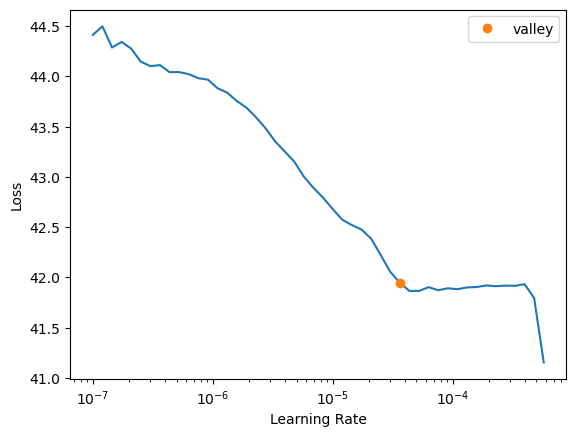

In [ ]:
learn.lr_find()

In [ ]:
import wandb
wandb.init(project='historical-maps')

wandb: Currently logged in as: mayrajeo. Use `wandb login --relogin` to force relogin


We trained the model for 1 frozen epochs (only the classification layer and decoder), and 10 unfrozen epochs (all layers unfrozen).

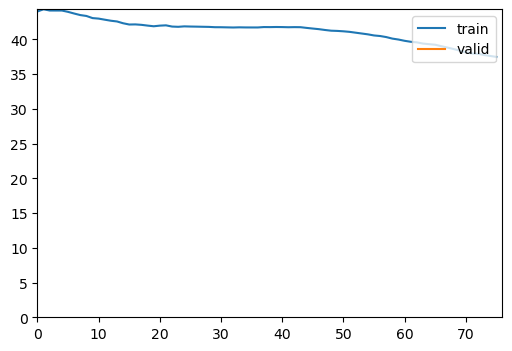

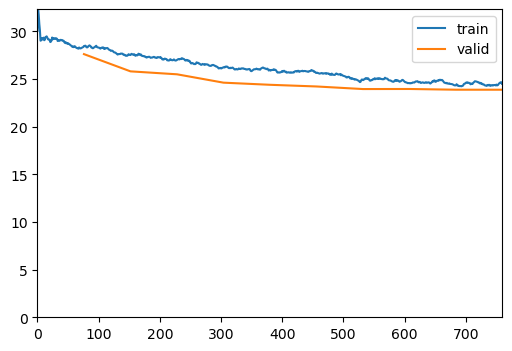

In [ ]:
learn.fine_tune(10, freeze_epochs=1, base_lr=1e-4, cbs=[ShowGraphCallback, WandbCallback(log_preds_every_epoch=True)])

In [ ]:
learn.to_fp32()

<fastai.learner.Learner>

In [ ]:
wandb.finish()

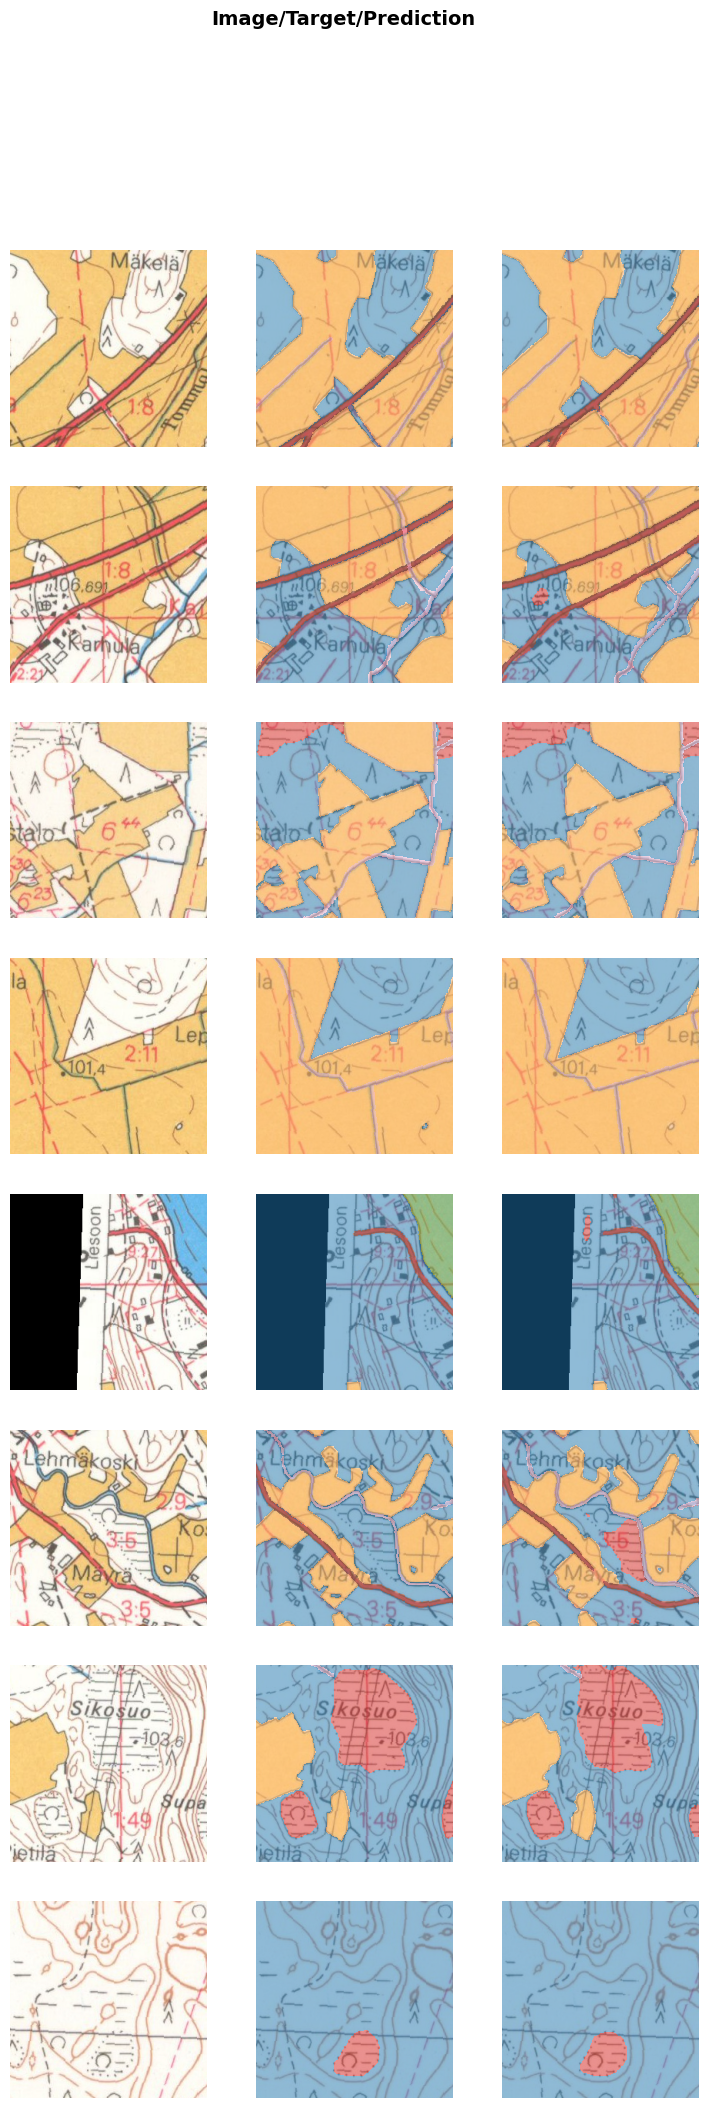

In [ ]:
learn.show_results(max_n=8)

In [ ]:
from fastai.interpret import * 
interp = SegmentationInterpretation.from_learner(learn)

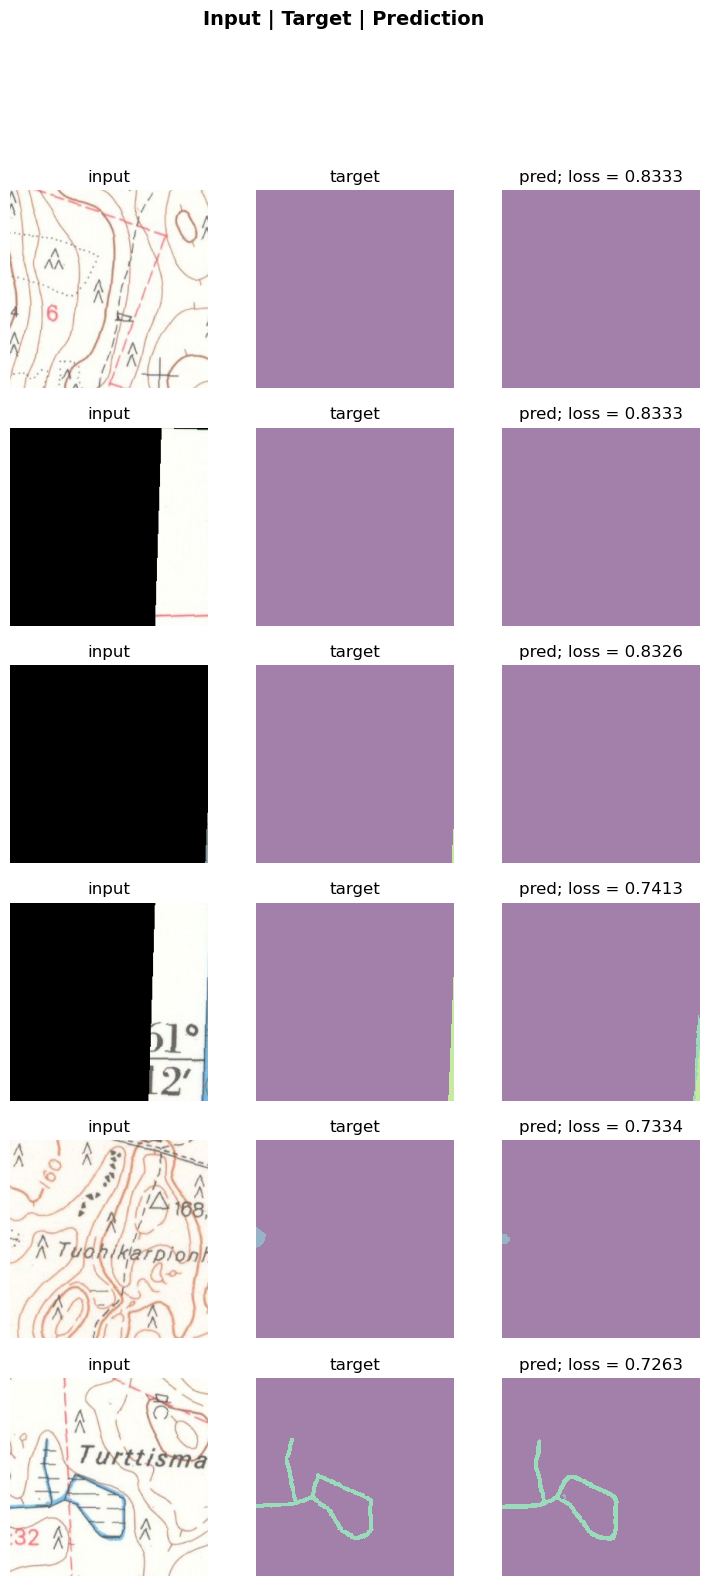

In [ ]:
interp.plot_top_losses(k=6, cmap='viridis')

In [ ]:
learn.path = Path('../models')
learn.export(fname='resnet152_diceloss.pkl')

# Test with remaining labeled data

The model performance is not only evaluated during training, but also using the holdout set.

## Example result patches

In [ ]:
valid_im_path = Path('../data/processed/val/')
val_images = [Path(valid_im_path/year/'raster_tiles'/f) for year in ['1965', '1984'] 
          for f in os.listdir(valid_im_path/year/'raster_tiles')]

In [ ]:
#learn = load_learner('../models/resnet152_focalloss.pkl', cpu=False)

In [ ]:
testdl = learn.dls.test_dl(val_images, with_labels=True)

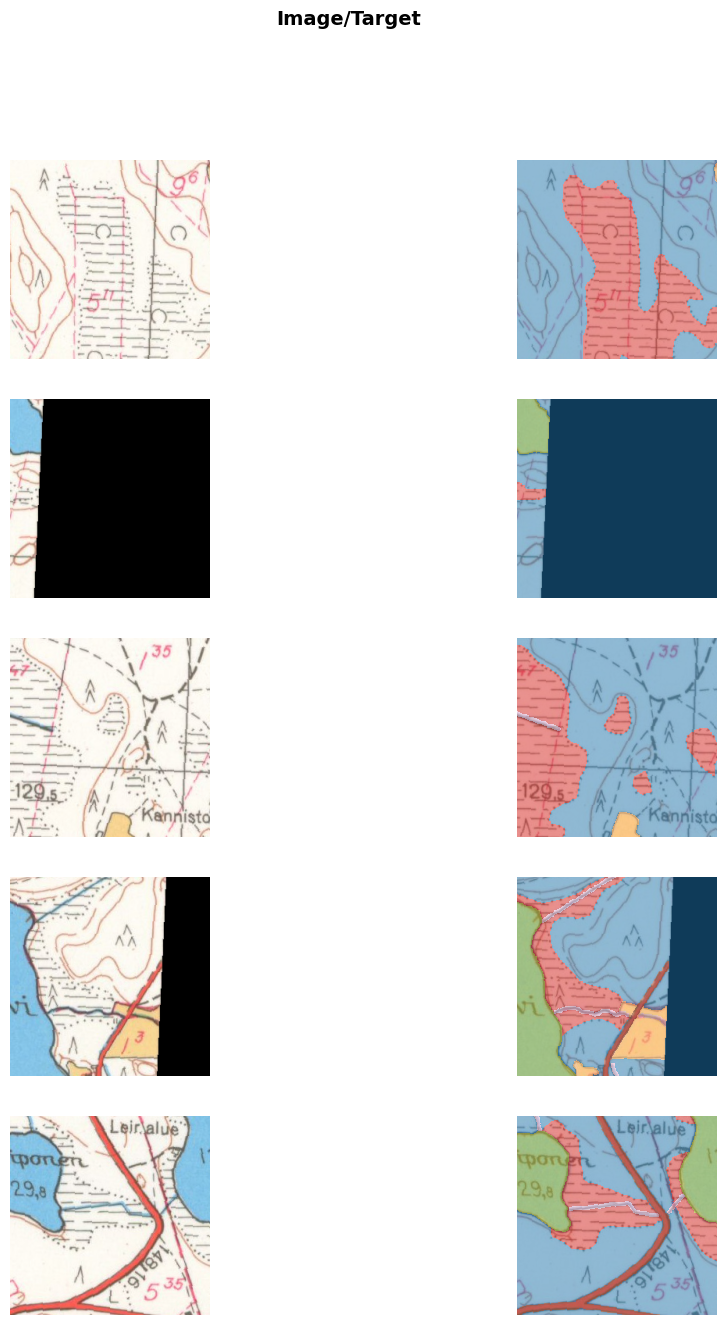

In [ ]:
testdl.show_batch(max_n = 10)

In [ ]:
learn.validate(dl=testdl)

(#3) [24.046770095825195,0.9240743868056707,0.8455290231391732]

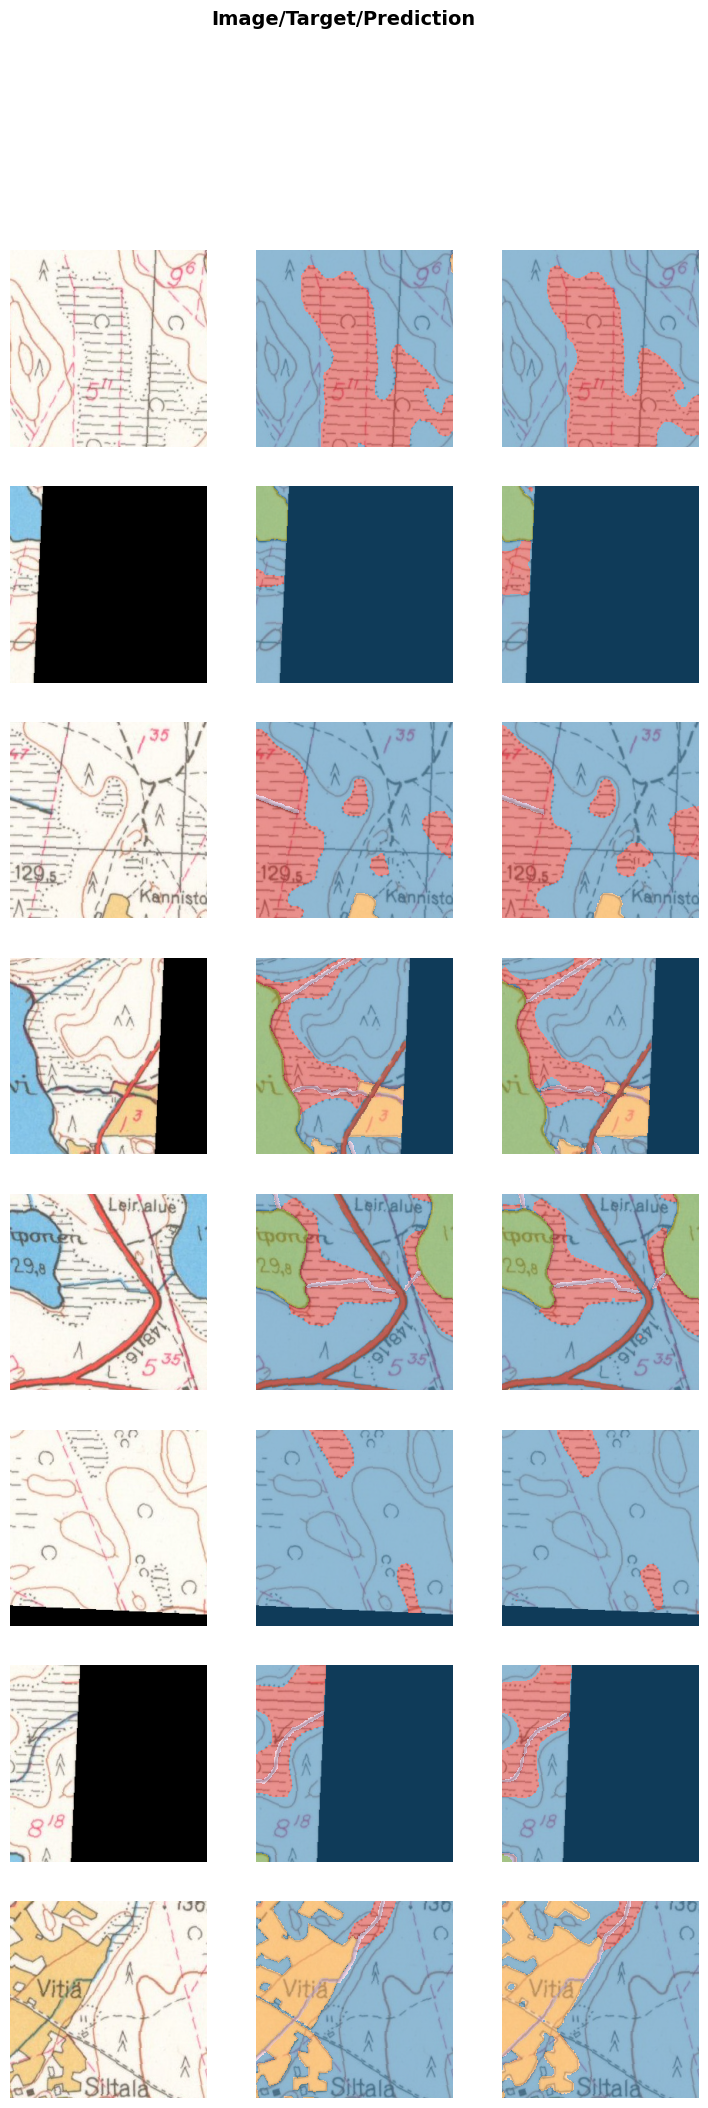

In [ ]:
learn.show_results(dl=testdl)

## Classwise metrics

These results are before any morphological post-processings, and before merging the results into large tiles.

In [ ]:
def dice(targs, preds, cls_id):
    inter = (torch.where(targs==cls_id, 1, 0)*torch.where(preds==cls_id, 1, 0)).float().sum()
    union = (torch.where(targs==cls_id, 1, 0)+torch.where(preds==cls_id, 1, 0)).float().sum()
    return 2 * inter/union if union > 0 else None

def jaccard(targs, preds, cls_id):
    inter = (torch.where(targs==cls_id, 1, 0)*torch.where(preds==cls_id, 1, 0)).float().sum()
    union = (torch.where(targs==cls_id, 1, 0)+torch.where(preds==cls_id, 1, 0)).float().sum()
    return inter/(union-inter) if union > 0 else None

In [ ]:
_, targs, preds = learn.get_preds(dl=testdl, with_decoded=True)

### Fields

In [ ]:
dice(targs, preds, 1)

TensorBase(0.9673)

In [ ]:
jaccard(targs, preds, 1)

TensorBase(0.9367)

### Marshes

In [ ]:
dice(targs, preds, 2)

TensorBase(0.8924)

In [ ]:
jaccard(targs, preds, 2)

TensorBase(0.8057)

### Roads

In [ ]:
dice(targs, preds, 3)

TensorBase(0.8732)

In [ ]:
jaccard(targs, preds, 3)

TensorBase(0.7750)

### Waterways

In [ ]:
dice(targs, preds, 4)

TensorBase(0.7887)

In [ ]:
jaccard(targs, preds, 4)

TensorBase(0.6511)

### Water bodies

In [ ]:
dice(targs, preds, 5)

TensorBase(0.9874)

In [ ]:
jaccard(targs, preds, 5)

TensorBase(0.9750)